<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Algorithmic Trading 

**Chapter 05 &mdash; Predicting Market Movements with Machine Learning**

## Using Linear Regression for Market Movement Prediction

### A Quick Review of Linear Regression

In [1]:
import os
import random
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
x = np.linspace(0, 10)

In [3]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
set_seeds() # <4>

In [4]:
y = x + np.random.standard_normal(len(x))

In [5]:
reg = np.polyfit(x, y, deg=1)

In [6]:
reg

array([0.94612934, 0.22855261])

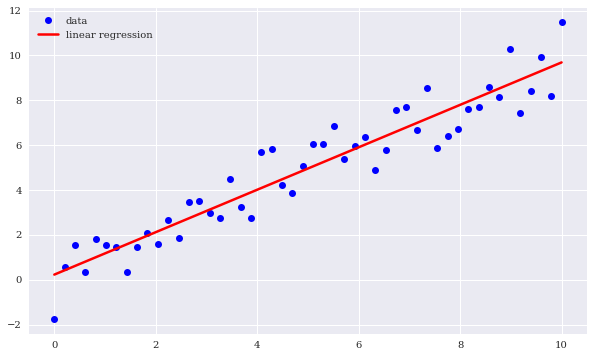

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='data')
plt.plot(x, np.polyval(reg, x), 'r', lw=2.5,
         label='linear regression')
plt.legend(loc=0);
# plt.savefig('../../images/ch05/lr_plot_1.png')

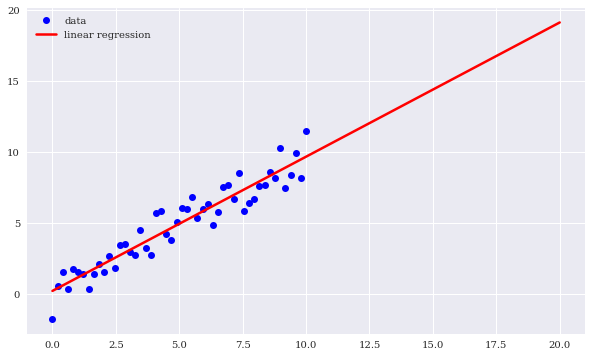

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='data')
xn = np.linspace(0, 20)
plt.plot(xn, np.polyval(reg, xn), 'r', lw=2.5,
         label='linear regression')
plt.legend(loc=0);
# plt.savefig('../../images/ch05/lr_plot_2.png')

### The Basic Idea for Price Prediction

In [9]:
x = np.arange(12)

In [10]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [11]:
lags = 3

In [12]:
m = np.zeros((lags + 1, len(x) - lags))

In [13]:
m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i:i - lags]

In [14]:
m.T

array([[ 0.,  1.,  2.,  3.],
       [ 1.,  2.,  3.,  4.],
       [ 2.,  3.,  4.,  5.],
       [ 3.,  4.,  5.,  6.],
       [ 4.,  5.,  6.,  7.],
       [ 5.,  6.,  7.,  8.],
       [ 6.,  7.,  8.,  9.],
       [ 7.,  8.,  9., 10.],
       [ 8.,  9., 10., 11.]])

In [15]:
reg = np.linalg.lstsq(m[:lags].T, m[lags], rcond=None)[0]

In [16]:
reg

array([-0.66666667,  0.33333333,  1.33333333])

In [17]:
np.dot(m[:lags].T, reg)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

### Predicting Index Levels

In [18]:
import pandas as pd

In [19]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [20]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [21]:
symbol = 'EUR='

In [22]:
data = pd.DataFrame(raw[symbol])

In [23]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [24]:
lags = 5

In [25]:
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['price'].shift(lag) # <1>
    cols.append(col)
data.dropna(inplace=True)

In [26]:
reg = np.linalg.lstsq(data[cols], data['price'],
                      rcond=None)[0]

In [27]:
reg

array([ 0.98635864,  0.02292172, -0.04769849,  0.05037365, -0.01208135])

In [28]:
data['prediction'] = np.dot(data[cols], reg)

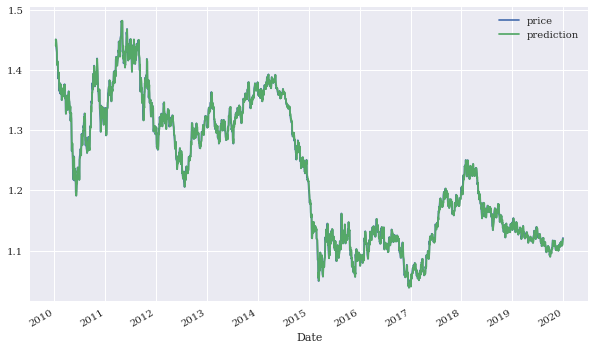

In [29]:
data[['price', 'prediction']].plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_3.png')

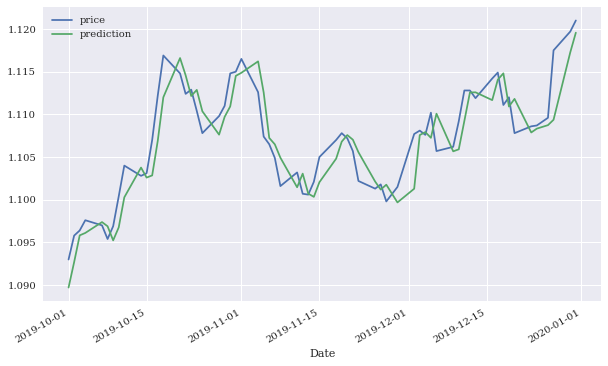

In [30]:
data[['price', 'prediction']].loc['2019-10-1':].plot(
            figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_4.png')

### Predicting Future Returns

In [31]:
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))

In [32]:
data.dropna(inplace=True)

In [33]:
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <3>
    cols.append(col)
data.dropna(inplace=True)

In [34]:
reg = np.linalg.lstsq(data[cols], data['return'],
                      rcond=None)[0]

In [35]:
reg

array([-0.015689  ,  0.00890227, -0.03634858,  0.01290924, -0.00636023])

In [36]:
data['prediction'] = np.dot(data[cols], reg)

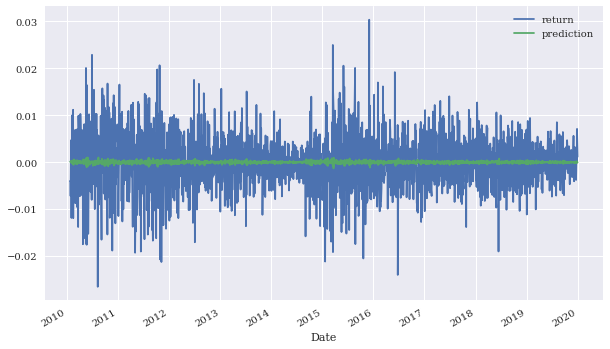

In [40]:
data[['return', 'prediction']].iloc[lags:].plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_5.png')

In [41]:
hits = np.sign(data['return'] *
               data['prediction']).value_counts()

In [38]:
hits

NameError: ignored

In [42]:
hits.values[0] / sum(hits)

0.499001996007984

### Prediction Future Market Direction

In [43]:
reg = np.linalg.lstsq(data[cols], np.sign(data['return']),
                      rcond=None)[0]

In [44]:
reg

array([-5.11938725, -2.24077248, -5.13080606, -3.03753232, -2.14819119])

In [45]:
data['prediction'] = np.sign(np.dot(data[cols], reg))

In [46]:
data['prediction'].value_counts()

 1.0    1300
-1.0    1205
Name: prediction, dtype: int64

In [47]:
hits = np.sign(data['return'] *
               data['prediction']).value_counts()

In [48]:
hits

 1.0    1301
-1.0    1191
 0.0      13
dtype: int64

In [49]:
hits.values[0] / sum(hits)

0.5193612774451097

### Vectorized Backtesting of Regression-based Strategy 

In [50]:
data.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5,prediction,return
Date,,,,,,,,
2010-01-20,1.4101,-0.005858,-0.008309,-0.000551,0.001103,-0.001310,1.0,-0.013874
2010-01-21,1.4090,-0.013874,-0.005858,-0.008309,-0.000551,0.001103,1.0,-0.000780
2010-01-22,1.4137,-0.000780,-0.013874,-0.005858,-0.008309,-0.000551,1.0,0.003330
2010-01-25,1.4150,0.003330,-0.000780,-0.013874,-0.005858,-0.008309,1.0,0.000919
2010-01-26,1.4073,0.000919,0.003330,-0.000780,-0.013874,-0.005858,1.0,-0.005457


In [55]:
data['strategy'] = data['prediction'] * data['return']
print(data)

             price     lag_1     lag_2     lag_3     lag_4     lag_5  \
Date                                                                   
2010-01-20  1.4101 -0.005858 -0.008309 -0.000551  0.001103 -0.001310   
2010-01-21  1.4090 -0.013874 -0.005858 -0.008309 -0.000551  0.001103   
2010-01-22  1.4137 -0.000780 -0.013874 -0.005858 -0.008309 -0.000551   
2010-01-25  1.4150  0.003330 -0.000780 -0.013874 -0.005858 -0.008309   
2010-01-26  1.4073  0.000919  0.003330 -0.000780 -0.013874 -0.005858   
...            ...       ...       ...       ...       ...       ...   
2019-12-24  1.1087  0.000722 -0.003784  0.000810 -0.003414  0.000628   
2019-12-26  1.1096  0.000090  0.000722 -0.003784  0.000810 -0.003414   
2019-12-27  1.1175  0.000811  0.000090  0.000722 -0.003784  0.000810   
2019-12-30  1.1197  0.007094  0.000811  0.000090  0.000722 -0.003784   
2019-12-31  1.1210  0.001967  0.007094  0.000811  0.000090  0.000722   

            prediction    return  strategy  
Date              

In [53]:
data[['return', 'strategy']].sum().apply(np.exp)

return      0.784026
strategy    1.654154
dtype: float64

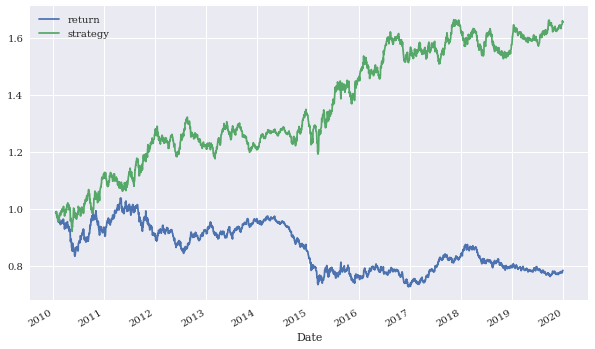

In [54]:
data[['return', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_6.png')

### Generalizing the Approach

In [57]:
import numpy as np
import pandas as pd


class LRVectorBacktester(object):
    ''' Class for the vectorized backtesting of
    Linear Regression-based trading strategies.
    Attributes
    ==========
    symbol: str
       TR RIC (financial instrument) to work with
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: int, float
        amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g. 0.5% = 0.005) per trade
    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    select_data:
        selects a sub-set of the data
    prepare_lags:
        prepares the lagged data for the regression
    fit_model:
        implements the regression step
    run_strategy:
        runs the backtest for the regression-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def __init__(self, symbol, start, end, amount, tc):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['returns'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()

    def select_data(self, start, end):
        ''' Selects sub-sets of the financial data.
        '''
        data = self.data[(self.data.index >= start) &
                         (self.data.index <= end)].copy()
        return data

    def prepare_lags(self, start, end):
        ''' Prepares the lagged data for the regression and prediction steps.
        '''
        data = self.select_data(start, end)
        self.cols = []
        for lag in range(1, self.lags + 1):
            col = f'lag_{lag}'
            data[col] = data['returns'].shift(lag)
            self.cols.append(col)
        data.dropna(inplace=True)
        self.lagged_data = data

    def fit_model(self, start, end):
        ''' Implements the regression step.
        '''
        self.prepare_lags(start, end)
        reg = np.linalg.lstsq(self.lagged_data[self.cols],
                              np.sign(self.lagged_data['returns']),
                              rcond=None)[0]
        self.reg = reg

    def run_strategy(self, start_in, end_in, start_out, end_out, lags=3):
        ''' Backtests the trading strategy.
        '''
        self.lags = lags
        self.fit_model(start_in, end_in)
        self.results = self.select_data(start_out, end_out).iloc[lags:]
        self.prepare_lags(start_out, end_out)
        prediction = np.sign(np.dot(self.lagged_data[self.cols], self.reg))
        self.results['prediction'] = prediction
        self.results['strategy'] = self.results['prediction'] * \
                                   self.results['returns']
        # determine when a trade takes place
        trades = self.results['prediction'].diff().fillna(0) != 0
        # subtract transaction costs from return when trade takes place
        self.results['strategy'][trades] -= self.tc
        self.results['creturns'] = self.amount * \
                        self.results['returns'].cumsum().apply(np.exp)
        self.results['cstrategy'] = self.amount * \
                        self.results['strategy'].cumsum().apply(np.exp)
        # gross performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | TC = %.4f' % (self.symbol, self.tc)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                     figsize=(10, 6))


if __name__ == '__main__':
    lrbt = LRVectorBacktester('.SPX', '2010-1-1', '2018-06-29', 10000, 0.0)
    print(lrbt.run_strategy('2010-1-1', '2019-12-31',
                            '2010-1-1', '2019-12-31'))
    print(lrbt.run_strategy('2010-1-1', '2015-12-31',
                            '2016-1-1', '2019-12-31'))
    lrbt = LRVectorBacktester('GDX', '2010-1-1', '2019-12-31', 10000, 0.001)
    print(lrbt.run_strategy('2010-1-1', '2019-12-31',
                            '2010-1-1', '2019-12-31', lags=5))
    print(lrbt.run_strategy('2010-1-1', '2016-12-31',
                            '2017-1-1', '2019-12-31', lags=5))

(22979.58, -830.48)
(12470.26, -1188.1)
(72792.63, 66956.47)
(12710.78, -325.73)


In [59]:
lrbt = LRVectorBacktester('EUR=', '2010-1-1', '2019-12-31',
                                     10000, 0.0)

In [60]:
lrbt.run_strategy('2010-1-1', '2019-12-31',
                  '2010-1-1', '2019-12-31', lags=5)

(17166.53, 9442.42)

In [61]:
lrbt.run_strategy('2010-1-1', '2017-12-31',
                  '2018-1-1', '2019-12-31', lags=5)

(10160.86, 791.87)

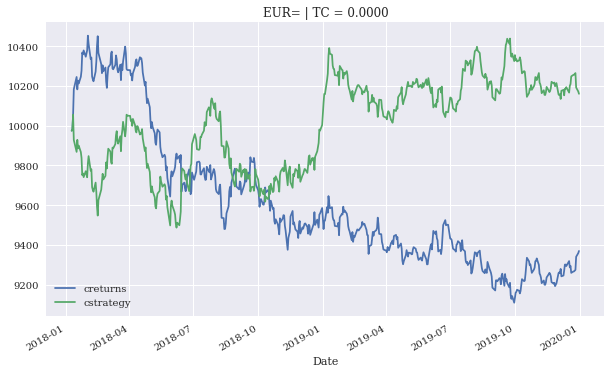

In [62]:
lrbt.plot_results()
# plt.savefig('../../images/ch05/lr_plot_7.png')

In [66]:
lrbt = LRVectorBacktester('GDX', '2010-1-1', '2019-12-31',
                                     10000, 0.002)

In [67]:
lrbt.run_strategy('2010-1-1', '2019-12-31',
                  '2010-1-1', '2019-12-31', lags=7)  

(23642.32, 17649.69)

In [68]:
lrbt.run_strategy('2010-1-1', '2014-12-31',
                  '2015-1-1', '2019-12-31', lags=7)

(28513.35, 14888.41)

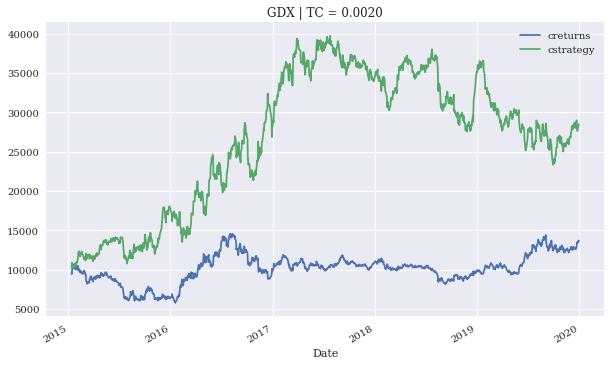

In [69]:
lrbt.plot_results()
# plt.savefig('../../images/ch05/lr_plot_8.png')

## Using Machine Learning for Market Movement Prediction

### Linear Regression with scikit-learn

In [70]:
x = np.arange(12)

In [71]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [72]:
lags = 3

In [73]:
m = np.zeros((lags + 1, len(x) - lags))

In [74]:
m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i:i - lags]

In [75]:
from sklearn import linear_model

In [76]:
lm = linear_model.LinearRegression()

In [77]:
lm.fit(m[:lags].T, m[lags])

LinearRegression()

In [78]:
lm.coef_

array([0.33333333, 0.33333333, 0.33333333])

In [79]:
lm.intercept_

2.0

In [80]:
lm.predict(m[:lags].T)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [81]:
lm = linear_model.LinearRegression(fit_intercept=False)

In [82]:
lm.fit(m[:lags].T, m[lags])

LinearRegression(fit_intercept=False)

In [83]:
lm.coef_

array([-0.66666667,  0.33333333,  1.33333333])

In [84]:
lm.intercept_

0.0

In [85]:
lm.predict(m[:lags].T)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

### A Simple Classification Problem

In [87]:
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
                  2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
                  4.5, 4.75, 5., 5.5])

In [88]:
success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
                    0, 1, 1, 1, 1, 1, 1])

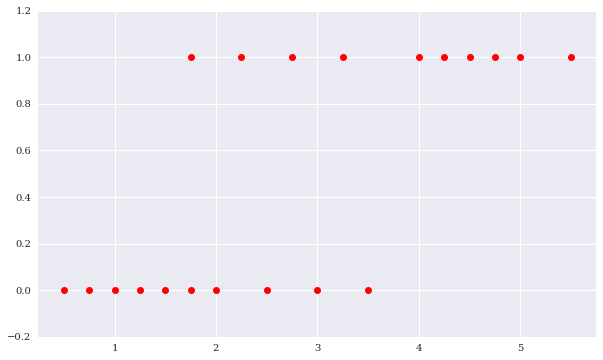

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.ylim(-0.2, 1.2);
# plt.savefig('../../images/ch05/ml_plot_1.png')

In [90]:
reg = np.polyfit(hours, success, deg=1)

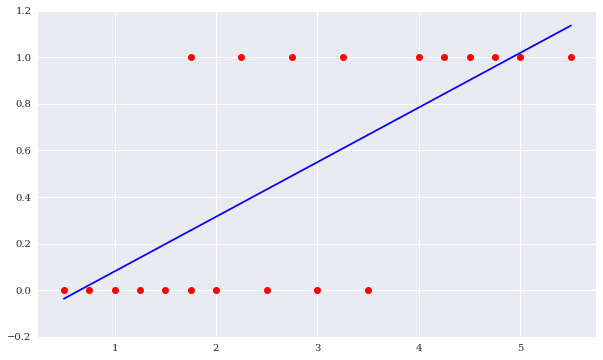

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.plot(hours, np.polyval(reg, hours), 'b')
plt.ylim(-0.2, 1.2);
# plt.savefig('../../images/ch05/ml_plot_2.png')

In [92]:
lm = linear_model.LogisticRegression(solver='lbfgs')

In [93]:
hrs = hours.reshape(1, -1).T

In [94]:
lm.fit(hrs, success)

LogisticRegression()

In [95]:
prediction = lm.predict(hrs)

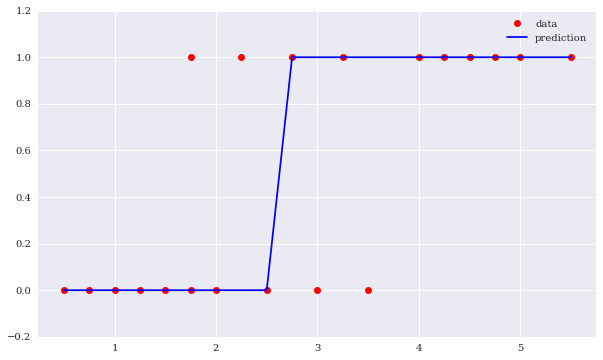

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro', label='data')
plt.plot(hours, prediction, 'b', label='prediction')
plt.legend(loc=0)
plt.ylim(-0.2, 1.2);
# plt.savefig('../../images/ch05/ml_plot_3.png')

In [97]:
prob = lm.predict_proba(hrs)

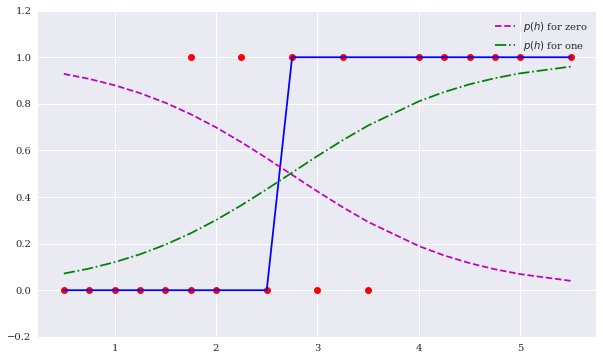

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.plot(hours, prediction, 'b')
plt.plot(hours, prob.T[0], 'm--',
         label='$p(h)$ for zero')
plt.plot(hours, prob.T[1], 'g-.',
         label='$p(h)$ for one')
plt.ylim(-0.2, 1.2)
plt.legend(loc=0);
# plt.savefig('../../images/ch05/ml_plot_4.png')

### Using Logistic Regression to Predict Market Direction

In [99]:
symbol = 'GLD'

In [100]:
data = pd.DataFrame(raw[symbol])

In [101]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [102]:
data['return'] = np.log(data['price'] / data['price'].shift(1))

In [103]:
data.dropna(inplace=True)

In [104]:
lags = 3

In [105]:
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['return'].shift(lag)
    cols.append(col)

In [106]:
data.dropna(inplace=True)

In [107]:
from sklearn.metrics import accuracy_score

In [108]:
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=1000)

In [109]:
lm.fit(data[cols], np.sign(data['return']))

LogisticRegression(C=10000000.0, max_iter=1000)

In [110]:
data['prediction'] = lm.predict(data[cols])

In [111]:
data['prediction'].value_counts()

 1.0    1983
-1.0     529
Name: prediction, dtype: int64

In [112]:
hits = np.sign(data['return'].iloc[lags:] *
               data['prediction'].iloc[lags:]
              ).value_counts()

In [113]:
hits

 1.0    1338
-1.0    1159
 0.0      12
dtype: int64

In [114]:
accuracy_score(data['prediction'],
               np.sign(data['return']))

0.5338375796178344

In [115]:
data['strategy'] = data['prediction'] * data['return']

In [116]:
data[['return', 'strategy']].sum().apply(np.exp)

return      1.289478
strategy    2.458716
dtype: float64

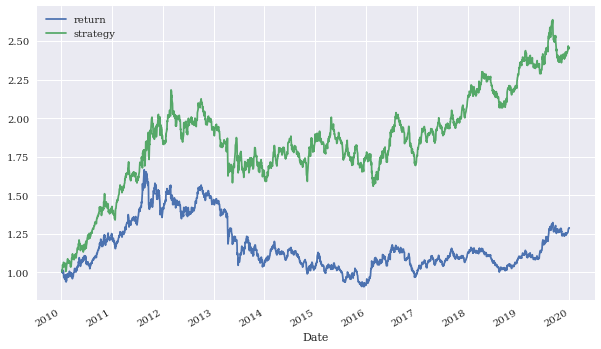

In [117]:
data[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(10, 6));
# plt.savefig('../../images/ch05/ml_plot_5.png')

In [118]:
data = pd.DataFrame(raw[symbol])

In [119]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [120]:
data['return'] = np.log(data['price'] / data['price'].shift(1))

In [121]:
lags = 5

In [122]:
cols = []
for lag in range(1, lags + 1):
    col = 'lag_%d' % lag
    data[col] = data['price'].shift(lag)
    cols.append(col)

In [123]:
data.dropna(inplace=True)

In [124]:
lm.fit(data[cols], np.sign(data['return']))

LogisticRegression(C=10000000.0, max_iter=1000)

In [125]:
data['prediction'] = lm.predict(data[cols])

In [126]:
data['prediction'].value_counts()

 1.0    2048
-1.0     463
Name: prediction, dtype: int64

In [127]:
hits = np.sign(data['return'].iloc[lags:] *
               data['prediction'].iloc[lags:]
              ).value_counts()

In [128]:
hits

 1.0    1330
-1.0    1164
 0.0      12
dtype: int64

In [129]:
accuracy_score(data['prediction'],
               np.sign(data['return']))

0.5308641975308642

In [130]:
data['strategy'] = data['prediction'] * data['return']

In [131]:
data[['return', 'strategy']].sum().apply(np.exp)

return      1.283110
strategy    2.535324
dtype: float64

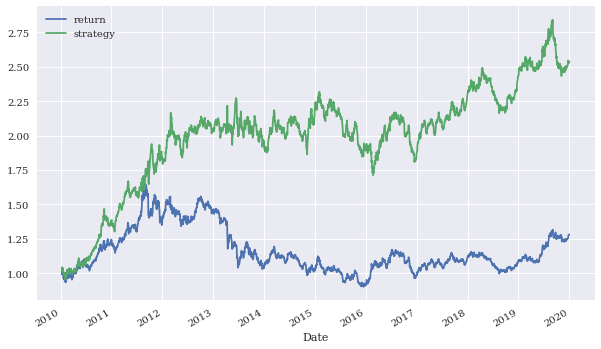

In [132]:
data[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(10, 6));
# plt.savefig('../../images/ch05/ml_plot_6.png')

### Generalizing the Approach

In [134]:
#
# Python Module with Class
# for Vectorized Backtesting
# of Machine Learning-based Strategies
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
import numpy as np
import pandas as pd
from sklearn import linear_model


class ScikitVectorBacktester(object):
    ''' Class for the vectorized backtesting of
    Machine Learning-based trading strategies.
    Attributes
    ==========
    symbol: str
        TR RIC (financial instrument) to work with
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: int, float
        amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g. 0.5% = 0.005) per trade
    model: str
        either 'regression' or 'logistic'
    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    select_data:
        selects a sub-set of the data
    prepare_features:
        prepares the features data for the model fitting
    fit_model:
        implements the fitting step
    run_strategy:
        runs the backtest for the regression-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def __init__(self, symbol, start, end, amount, tc, model):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        if model == 'regression':
            self.model = linear_model.LinearRegression()
        elif model == 'logistic':
            self.model = linear_model.LogisticRegression(C=1e6,
                solver='lbfgs', multi_class='ovr', max_iter=1000)
        else:
            raise ValueError('Model not known or not yet implemented.')
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['returns'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()

    def select_data(self, start, end):
        ''' Selects sub-sets of the financial data.
        '''
        data = self.data[(self.data.index >= start) &
                         (self.data.index <= end)].copy()
        return data

    def prepare_features(self, start, end):
        ''' Prepares the feature columns for the regression and prediction steps.
        '''
        self.data_subset = self.select_data(start, end)
        self.feature_columns = []
        for lag in range(1, self.lags + 1):
            col = 'lag_{}'.format(lag)
            self.data_subset[col] = self.data_subset['returns'].shift(lag)
            self.feature_columns.append(col)
        self.data_subset.dropna(inplace=True)

    def fit_model(self, start, end):
        ''' Implements the fitting step.
        '''
        self.prepare_features(start, end)
        self.model.fit(self.data_subset[self.feature_columns],
                       np.sign(self.data_subset['returns']))

    def run_strategy(self, start_in, end_in, start_out, end_out, lags=3):
        ''' Backtests the trading strategy.
        '''
        self.lags = lags
        self.fit_model(start_in, end_in)
        # data = self.select_data(start_out, end_out)
        self.prepare_features(start_out, end_out)
        prediction = self.model.predict(
            self.data_subset[self.feature_columns])
        self.data_subset['prediction'] = prediction
        self.data_subset['strategy'] = (self.data_subset['prediction'] *
                                        self.data_subset['returns'])
        # determine when a trade takes place
        trades = self.data_subset['prediction'].diff().fillna(0) != 0
        # subtract transaction costs from return when trade takes place
        self.data_subset['strategy'][trades] -= self.tc
        self.data_subset['creturns'] = (self.amount *
                        self.data_subset['returns'].cumsum().apply(np.exp))
        self.data_subset['cstrategy'] = (self.amount *
                        self.data_subset['strategy'].cumsum().apply(np.exp))
        self.results = self.data_subset
        # absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | TC = %.4f' % (self.symbol, self.tc)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                     figsize=(10, 6))


if __name__ == '__main__':
    scibt = ScikitVectorBacktester('.SPX', '2010-1-1', '2019-12-31',
                                   10000, 0.0, 'regression')
    print(scibt.run_strategy('2010-1-1', '2019-12-31',
                             '2010-1-1', '2019-12-31'))
    print(scibt.run_strategy('2010-1-1', '2016-12-31',
                             '2017-1-1', '2019-12-31'))
    scibt = ScikitVectorBacktester('.SPX', '2010-1-1', '2019-12-31',
                                   10000, 0.0, 'logistic')
    print(scibt.run_strategy('2010-1-1', '2019-12-31',
                             '2010-1-1', '2019-12-31'))
    print(scibt.run_strategy('2010-1-1', '2016-12-31',
                             '2017-1-1', '2019-12-31'))
    scibt = ScikitVectorBacktester('.SPX', '2010-1-1', '2019-12-31',
                                   10000, 0.001, 'logistic')
    print(scibt.run_strategy('2010-1-1', '2019-12-31',
                             '2010-1-1', '2019-12-31', lags=15))
    print(scibt.run_strategy('2010-1-1', '2013-12-31',
                             '2014-1-1', '2019-12-31', lags=15))

(11624.45, -16673.78)
(10245.48, -3993.3)
(31490.16, 3191.93)
(13538.46, -700.32)
(32629.37, 3048.08)
(16426.27, -1243.14)


In [136]:
scibt = ScikitVectorBacktester('EUR=',
                                   '2010-1-1', '2019-12-31',
                                   10000, 0.0, 'logistic')

In [137]:
scibt.run_strategy('2015-1-1', '2019-12-31',
                   '2015-1-1', '2019-12-31', lags=15)

(12192.18, 2189.5)

In [138]:
scibt.run_strategy('2016-1-1', '2018-12-31',
                   '2019-1-1', '2019-12-31', lags=15)

(10580.54, 729.93)

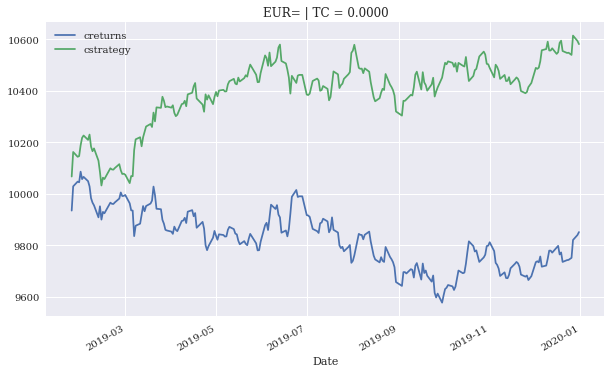

In [139]:
scibt.plot_results()
# plt.savefig('../../images/ch05/ml_plot_7.png')

In [141]:
scibt = ScikitVectorBacktester('GDX',
                                   '2010-1-1', '2019-12-31',
                                   10000, 0.00, 'logistic')

In [142]:
scibt.run_strategy('2013-1-1', '2017-12-31',
                   '2018-1-1', '2018-12-31', lags=10)

(12686.81, 4032.73)

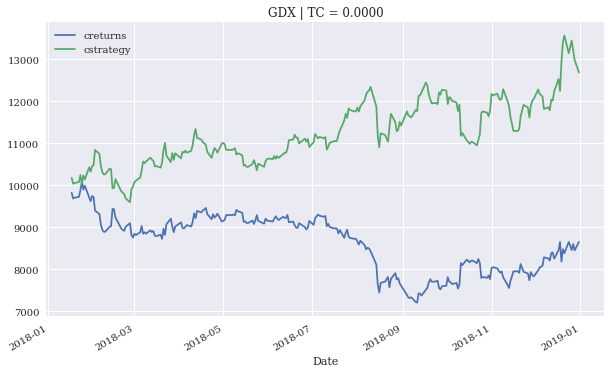

In [143]:
scibt.plot_results()
# plt.savefig('../../images/ch05/ml_plot_8.png')

In [ ]:
scibt = SCI.ScikitVectorBacktester('GDX',
                                   '2010-1-1', '2019-12-31',
                                   10000, 0.0025, 'logistic')

In [ ]:
scibt.run_strategy('2013-1-1', '2017-12-31',
                   '2018-1-1', '2018-12-31', lags=10)

(9588.48, 934.4)

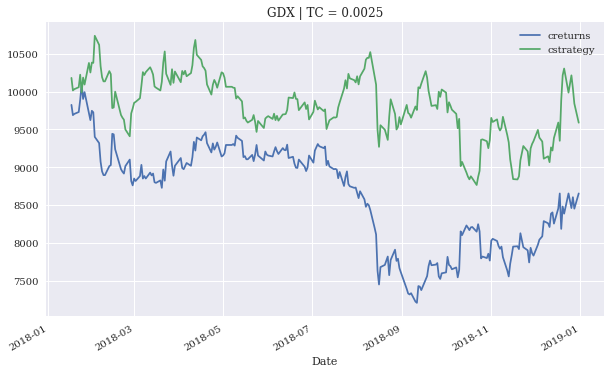

In [ ]:
scibt.plot_results()
# plt.savefig('../../images/ch05/ml_plot_8_a.png')

## Using Deep Learning for Market Movement Prediction

#### The Simple Classification Problem Revisited 

In [144]:
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
                  2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
                  4.5, 4.75, 5., 5.5])

In [145]:
success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
                    0, 1, 1, 1, 1, 1, 1]) 

In [146]:
data = pd.DataFrame({'hours': hours, 'success': success})

In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   hours    20 non-null     float64
 1   success  20 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 448.0 bytes


In [148]:
from sklearn.neural_network import MLPClassifier

In [149]:
model = MLPClassifier(hidden_layer_sizes=[32],
                     max_iter=1000, random_state=100)

In [150]:
model.fit(data['hours'].values.reshape(-1, 1), data['success'])

MLPClassifier(hidden_layer_sizes=[32], max_iter=1000, random_state=100)

In [151]:
data['prediction'] = model.predict(data['hours'].values.reshape(-1, 1)) # <2>

In [ ]:
data.tail()

,hours,success,prediction
15,4.25,1,1
16,4.50,1,1
17,4.75,1,1
18,5.00,1,1
19,5.50,1,1


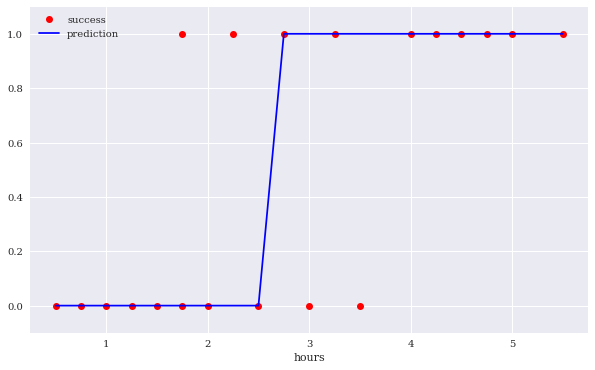

In [152]:
data.plot(x='hours', y=['success', 'prediction'],
          style=['ro', 'b-'], ylim=[-.1, 1.1],
          figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_1.png')

### Using Deep Neural Networks to Predict Market Direction

In [153]:
symbol = 'EUR='

In [154]:
data = pd.DataFrame(raw[symbol])

In [155]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [156]:
data['return'] = np.log(data['price'] /
                         data['price'].shift(1)) 

In [157]:
data['direction'] = np.where(data['return'] > 0, 1, 0)

In [158]:
lags = 5


In [159]:
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [160]:
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007


In [165]:
!pip install tensorflow
!pip install keras
!pip install keras.optimizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement keras.optimizers (from versions: none)
ERROR: No matching distribution found for keras.optimizers


In [167]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [169]:
optimizer = Adam(learning_rate=0.0001)

In [170]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [171]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
        input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # <5>
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [172]:
cutoff = '2017-12-31'

In [173]:
training_data = data[data.index < cutoff].copy()

In [174]:
mu, std = training_data.mean(), training_data.std()

In [175]:
training_data_ = (training_data - mu) / std

In [176]:
test_data = data[data.index >= cutoff].copy()

In [177]:
test_data_ = (test_data - mu) / std

In [178]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

CPU times: user 7.13 s, sys: 394 ms, total: 7.53 s
Wall time: 11.1 s


In [179]:
res = pd.DataFrame(model.history.history)

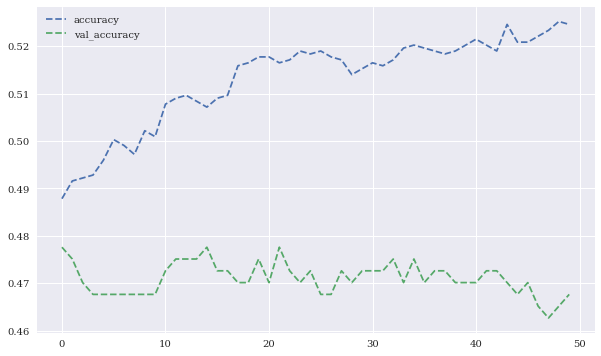

In [180]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');
# plt.savefig('../../images/ch05/dnn_plot_metrics.png')

In [181]:
model.evaluate(training_data_[cols], training_data['direction'])

63/63 [==============================] - 0s 1ms/step - loss: 0.7557 - accuracy: 0.5147


[0.7556682229042053, 0.5146985650062561]

In [184]:
pred = model.predict(training_data_[cols])

In [185]:
pred[:30].flatten()

array([0.38455668, 0.31619626, 0.24899617, 0.30393046, 0.3839355 ,
       0.5522946 , 0.6369066 , 0.6725821 , 0.5511326 , 0.4951752 ,
       0.32323474, 0.46697938, 0.5651246 , 0.5803309 , 0.5542621 ,
       0.48626313, 0.4443364 , 0.3587317 , 0.5597322 , 0.62495553,
       0.4615748 , 0.43579066, 0.23820543, 0.55675644, 0.26983032,
       0.5207985 , 0.27652794, 0.5623131 , 0.4001009 , 0.43097484],
      dtype=float32)

In [186]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [187]:
training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])

In [188]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.826569
strategy    0.826569
dtype: float64

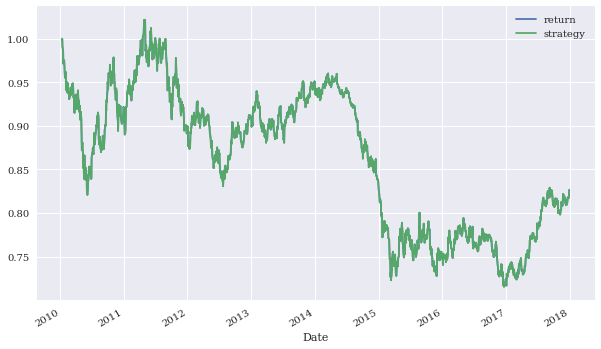

In [189]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_2.png')

In [190]:
model.evaluate(test_data_[cols], test_data['direction'])

16/16 [==============================] - 0s 2ms/step - loss: 0.7293 - accuracy: 0.5050


[0.7292723655700684, 0.5049701929092407]

In [192]:
pred = model.predict(test_data_[cols])

In [193]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [194]:
test_data['prediction'].value_counts()

1    503
Name: prediction, dtype: int64

In [195]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [196]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    0.934478
dtype: float64

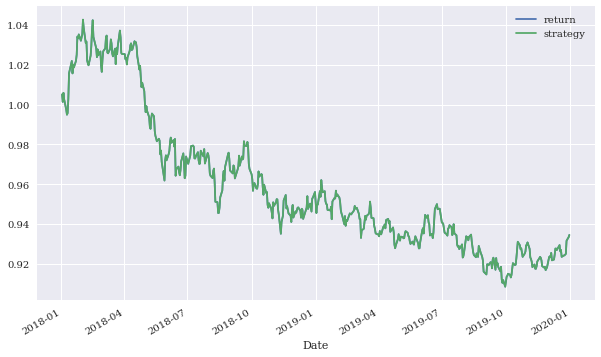

In [197]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_3.png')

### Adding Different Types of Features

In [198]:
data['momentum'] = data['return'].rolling(5).mean().shift(1)

In [199]:
data['volatility'] = data['return'].rolling(20).std().shift(1)

In [200]:
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)

In [201]:
data.dropna(inplace=True)

In [202]:
cols.extend(['momentum', 'volatility', 'distance'])

In [203]:
print(data.round(4).tail())

             price  return  direction   lag_1   lag_2   lag_3   lag_4   lag_5  \
Date                                                                            
2019-12-24  1.1087  0.0001          1  0.0007 -0.0038  0.0008 -0.0034  0.0006   
2019-12-26  1.1096  0.0008          1  0.0001  0.0007 -0.0038  0.0008 -0.0034   
2019-12-27  1.1175  0.0071          1  0.0008  0.0001  0.0007 -0.0038  0.0008   
2019-12-30  1.1197  0.0020          1  0.0071  0.0008  0.0001  0.0007 -0.0038   
2019-12-31  1.1210  0.0012          1  0.0020  0.0071  0.0008  0.0001  0.0007   

            momentum  volatility  distance  
Date                                        
2019-12-24   -0.0010      0.0024    0.0005  
2019-12-26   -0.0011      0.0024    0.0004  
2019-12-27   -0.0003      0.0024    0.0012  
2019-12-30    0.0010      0.0028    0.0089  
2019-12-31    0.0021      0.0028    0.0110  


In [204]:
training_data = data[data.index < cutoff].copy()

In [205]:
mu, std = training_data.mean(), training_data.std()

In [206]:
training_data_ = (training_data - mu) / std

In [207]:
test_data = data[data.index >= cutoff].copy() 

In [208]:
test_data_ = (test_data - mu) / std

In [209]:
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [210]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

CPU times: user 3.21 s, sys: 207 ms, total: 3.42 s
Wall time: 3.29 s


In [211]:
model.evaluate(training_data_[cols], training_data['direction'])

62/62 [==============================] - 0s 1ms/step - loss: 0.6816 - accuracy: 0.5646


[0.6816269755363464, 0.5646397471427917]

In [213]:
pred = model.predict(training_data_[cols])

In [214]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [215]:
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']

In [216]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.901074
strategy    0.901074
dtype: float64

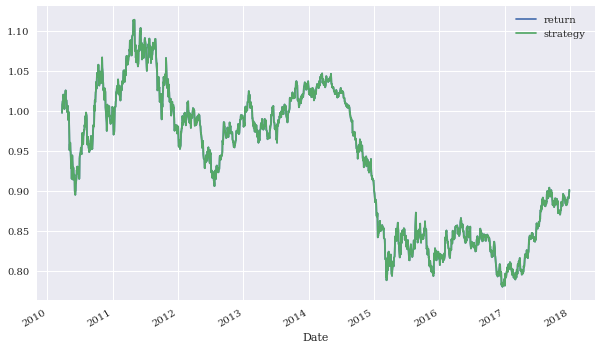

In [217]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_4.png')

In [218]:
model.evaluate(test_data_[cols], test_data['direction'])

16/16 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5507


[0.6931276321411133, 0.5506958365440369]

In [220]:
pred = model.predict(test_data_[cols])

In [221]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [222]:
test_data['prediction'].value_counts()

1    503
Name: prediction, dtype: int64

In [223]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [224]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    0.934478
dtype: float64

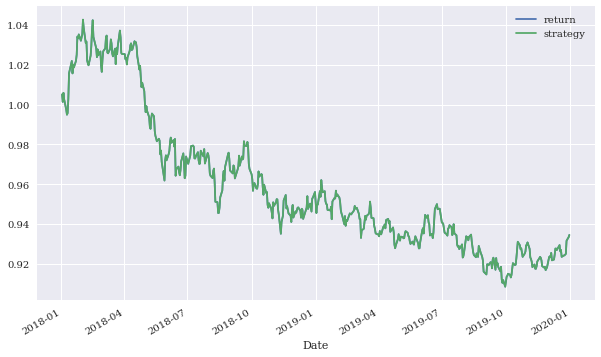

In [225]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_5.png')

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>